In [25]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
import pandas as pd
import seaborn as sns
import warnings

In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.datasets import make_blobs, load_wine

from data_functions import load_data
from error_probs_model import ErrorProbsModel
from parzen_window_classifier import PWC

from functools import partial

from calibration import get_calibration_errors, get_ece, get_mce
from numpy.random import default_rng
rng = default_rng(12345)

In [27]:
data_set_names = pd.read_csv('./data/data_set_ids.csv').name.values

In [28]:
data_set_names

array(['breast-cancer-wisconsin', 'blood-transfusion',
       'pima-indians-diabetes', 'ionosphere', 'sonar', 'biodegradation',
       'vehicle', 'ecoli', 'glass', 'vertebra-column', 'user-knowledge',
       'kc2', 'parkinsons', 'banknote', 'seeds', 'prnn-craps',
       'chscase-vine', 'wine', 'iris', 'segment', 'balance-scale',
       'seismic-bumps', 'steel-plates-fault', 'phoneme', 'satimage',
       'wind'], dtype=object)

In [29]:
def eval_classifier(classifier, X_test, y_test, results):
	
	y_pred = classifier.predict(X_test)
	results['accuracies'].append(np.round(np.sum(y_pred == y_test) / len(y_test), 3))

	results['mce'].append(np.round(get_mce(y_test, y_pred), 3))
	results['ece'].append(np.round(get_ece(y_test, y_pred), 3))
	

In [30]:
X, y_true, y = load_data('sonar-simulated-o')

X_train, X_test, y_train_idx, y_test_idx = train_test_split(X, np.arange(len(y_true)), test_size=0.4, random_state=42)

y_train = y[y_train_idx]
y_test = y_true[y_test_idx]
# Standardize
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
n_classes = len(np.unique(y_train))
budget = 5*n_classes

n_iterations = len(X_test) // budget

n_annotators = 5


In [64]:
y_DL = np.empty_like(y_train, dtype=float)
y_DL[:] = np.nan
# initial choice
idx = [i for l in [rng.choice(np.where(y_train==c)[0],5)
				    for c in np.unique(y_train)] for i in l]

mask = np.zeros_like(y_train, dtype=bool)
annotators = rng.integers(0,n_annotators, budget)

mask[idx, annotators] = True
y_DL[mask] = y_train[mask]

In [65]:
X_test.shape

(84, 60)

In [70]:
mask = np.sum(~np.isnan(y_DL), axis=1) == 0
mask[:] = True
#mask = ...
X_train[mask]

array([[-0.07044588, -0.98665633, -0.22904372, ..., -0.00740622,
         0.12816859,  0.07295357],
       [-0.1821064 , -0.21435676,  0.01202935, ..., -1.13770909,
        -0.7239448 , -0.07781714],
       [-0.07903515,  0.61109704,  2.0521102 , ...,  1.52909925,
         0.46505063,  0.37449497],
       ...,
       [-0.08762442, -0.60832334, -0.49422409, ..., -1.226014  ,
        -0.54559549,  0.34936652],
       [ 0.48785675,  0.10456858,  0.08435127, ..., -0.16635506,
        -0.36724617,  0.60065103],
       [ 1.31672142,  2.57467654,  2.56137705, ...,  0.41645736,
         3.10065718,  1.5304037 ]], shape=(124, 60))

In [67]:
def check(**kwargs):
	return kwargs['name']

check(name='hello', other =True)

'hello'

In [68]:
# y_train complete annotations
# y_DL already selected annotations
def select_fixed_annotator(**kwargs):

	n_instances = kwargs['X_selected'].shape[0]
	annotators = np.zeros(n_instances, dtype=int) + kwargs['annotator']

	return annotators

def select_random_annotator(**kwargs):

	n_annotators = kwargs['y_DL'].shape[1]
	n_instances = kwargs['X_selected'].shape[0]
	annotators = rng.choice(np.arange(n_annotators), n_instances)

	return annotators

def select_annotator_epm(**kwargs):
	
	epm = ErrorProbsModel(kwargs['n_classes'])
	epm.fit(kwargs['X_train'], kwargs['y_DL'])
	label_accuracy = epm.predict(kwargs['X_selected'])
	annotators = np.argmax(label_accuracy, axis=1)

	return annotators

def selection(n, classifier, query_strategy, annotator_selection, X_train, y_train, y_DL, relabel=True):

	n_classes = len(np.unique(y_train))

	mask = np.sum(~np.isnan(y_DL), axis=1) == 0
	if relabel:
		mask[:] = True
	instances_idx = query_strategy(n, classifier, X_train, y_DL, mask)
	annotators_idx = annotator_selection(X_train=X_train, X_selected=X_train[instances_idx], y_DL=y_DL,
									  	 n_classes=n_classes)
	
	y_DL[instances_idx, annotators_idx] = y_train[instances_idx, annotators_idx]

	return y_DL

def margin_qs(n, classifier, X, y, mask):

	p = classifier.predict_proba(X)
	instances_idx = np.argsort(np.diff(np.sort(p, axis=1))[:,-1])
	instances_idx = np.array([x for x in instances_idx if x not in np.arange(X.shape[0])[~mask]])
	instances_idx = instances_idx[:n]

	return instances_idx

def initial_choice(y_train, budget, n_annotators):

	y_DL = np.empty_like(y_train, dtype=float)
	y_DL[:] = np.nan
	
	# initial choice
	idx = [i for l in [rng.choice(np.where(y_train==c)[0],5,replace=False)
						for c in np.unique(y_train)] for i in l]

	mask = np.zeros_like(y_train, dtype=bool)
	annotators = rng.integers(0, n_annotators, budget)

	mask[idx, annotators] = True
	y_DL[mask] = y_train[mask]
	
	return y_DL

In [37]:
def eval_classifier(classifier, X_test, y_test, results):
	
	y_pred = classifier.predict(X_test)
	results['accuracies'].append(np.round(np.sum(y_pred == y_test) / len(y_test), 3))

	results['mce'].append(np.round(get_mce(y_test, y_pred), 3))
	results['ece'].append(np.round(get_ece(y_test, y_pred), 3))



In [49]:
def run_experiment(data_set_name, seed, classifier, nbudget=5, query_strategy=margin_qs, 
				   annnotator_selection=select_random_annotator, verbose=False, relabel=True):
	
	X, y_true, y = load_data(data_set_name)

	n_classes = len(np.unique(y_true))
	n_instances, n_annotators = y.shape

	budget = nbudget * n_classes

	X_train, X_test, y_train_idx, y_test_idx = train_test_split(X, np.arange(len(y_true)), test_size=0.4, random_state=seed)

	y_train = y[y_train_idx]
	y_test = y_true[y_test_idx]

	y_DL = initial_choice(y_train, budget, n_annotators)
	
	# Standardize
	scaler = StandardScaler().fit(X_train)
	X_train = scaler.transform(X_train)
	X_test = scaler.transform(X_test)

	if isinstance(classifier, partial) and classifier.func == PWC:
		classifier = classifier(n_classes=n_classes)
	else:
		classifier = classifier()
	
	n_iterations = np.minimum(len(X_test) // (budget), 50)
	
	results = {'accuracies': [], 'mce': [], 'ece': [], 'api': [], 'classes' : n_classes,
			 'instances' : n_instances, 'annotators': n_annotators, 'max_annotations': [],
			 'n_annotations' : []}

	# AL loop
	for i in range(n_iterations):

		classifier.fit(X_train, y_DL)
		
		eval_classifier(classifier, X_test, y_test, results)

		y_DL = selection(budget, classifier, query_strategy, annnotator_selection, 
				   		 X_train, y_train, y_DL, relabel=relabel)

		n_annotations = np.sum(~np.isnan(y_DL), axis=1)
		results['n_annotations'].append(n_annotations)
		results['max_annotations'].append(np.max(n_annotations))
		mask = n_annotations != 0
		results['api'].append(np.mean(n_annotations[mask]).round(2))

		if verbose:
			print(f'Iteration: {i}. Accuracy: {results['accuracies'][-1]}. MCE: {results['mce'][-1]}. ECE: {results['ece'][-1]}')
			print(f'Annotations per instance: {results['api'][-1]}. Max annotations: {results['max_annotations'][-1]}')
	
	return results

In [50]:
np.max(np.sum(~np.isnan(y_train), axis=1))

np.int64(5)

In [51]:
annotator_selection = partial(select_fixed_annotator, annotator=1)
with warnings.catch_warnings():
	warnings.filterwarnings('ignore', category=FutureWarning)
	res = run_experiment(data_set_name='phoneme-simulated-o', seed=1, classifier=partial(PWC, metric='rbf'), 
						nbudget=5, query_strategy=margin_qs, annnotator_selection=annotator_selection, verbose=True, relabel=False)

Iteration: 0. Accuracy: 0.528. MCE: 0.768. ECE: 0.256
Annotations per instance: 1.0. Max annotations: 1
Iteration: 1. Accuracy: 0.581. MCE: 0.679. ECE: 0.238
Annotations per instance: 1.0. Max annotations: 1
Iteration: 2. Accuracy: 0.678. MCE: 0.613. ECE: 0.078
Annotations per instance: 1.0. Max annotations: 1
Iteration: 3. Accuracy: 0.745. MCE: 0.301. ECE: 0.029
Annotations per instance: 1.0. Max annotations: 1
Iteration: 4. Accuracy: 0.752. MCE: 0.327. ECE: 0.043
Annotations per instance: 1.0. Max annotations: 1
Iteration: 5. Accuracy: 0.726. MCE: 0.343. ECE: 0.021
Annotations per instance: 1.0. Max annotations: 1
Iteration: 6. Accuracy: 0.718. MCE: 0.402. ECE: 0.024
Annotations per instance: 1.0. Max annotations: 1
Iteration: 7. Accuracy: 0.704. MCE: 0.568. ECE: 0.01
Annotations per instance: 1.0. Max annotations: 1
Iteration: 8. Accuracy: 0.72. MCE: 0.408. ECE: 0.029
Annotations per instance: 1.0. Max annotations: 1
Iteration: 9. Accuracy: 0.731. MCE: 0.345. ECE: 0.027
Annotations 

In [92]:
def plot_mean_std(ax, data, x, label, color, linestyle='-'):

	mean = np.mean(data, axis=0)
	std = np.std(data, axis=0)

	lower_bound = np.maximum(mean - std, 0)  # Prevent negative values
	upper_bound = mean + std

	ax.plot(x, mean, label=label, color=color, linewidth=2, linestyle=linestyle)
	ax.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.3, label=f"±1 Std Dev {label}")

In [98]:
data_set_names

array(['breast-cancer-wisconsin', 'blood-transfusion',
       'pima-indians-diabetes', 'ionosphere', 'sonar', 'biodegradation',
       'vehicle', 'ecoli', 'glass', 'vertebra-column', 'user-knowledge',
       'kc2', 'parkinsons', 'banknote', 'seeds', 'prnn-craps',
       'chscase-vine', 'wine', 'iris', 'segment', 'balance-scale',
       'seismic-bumps', 'steel-plates-fault', 'phoneme', 'satimage',
       'wind'], dtype=object)

Data set: breast-cancer-wisconsin-simulated-o. Simulations: 20
Accuracy:0.906. ECE: 0.005. MCE: 0.02
Annotations per instance: 0.67. Max annotations: 1.1


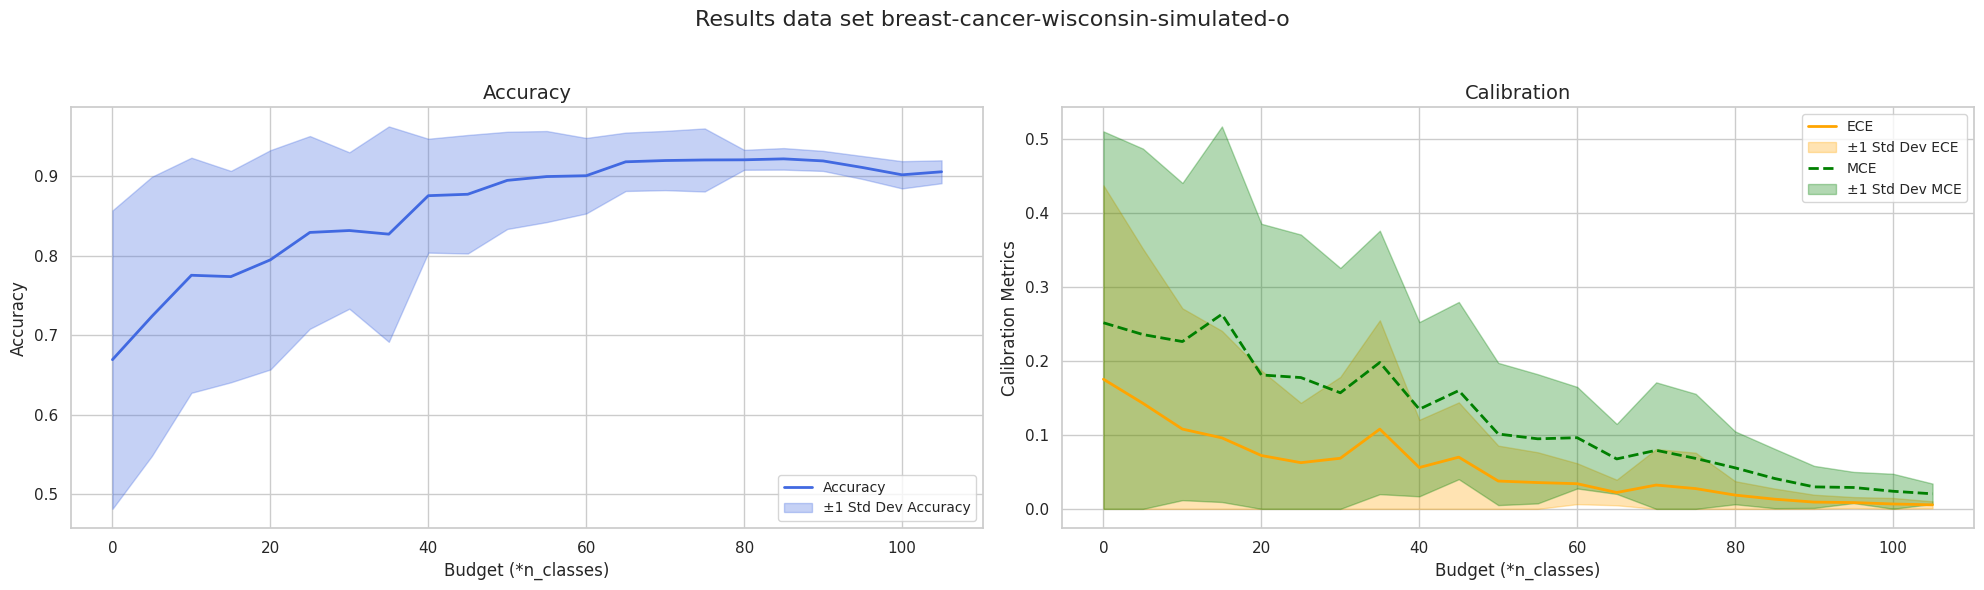

Data set: biodegradation-simulated-o. Simulations: 20
Accuracy:0.643. ECE: 0.287. MCE: 0.481
Annotations per instance: 0.68. Max annotations: 1.0


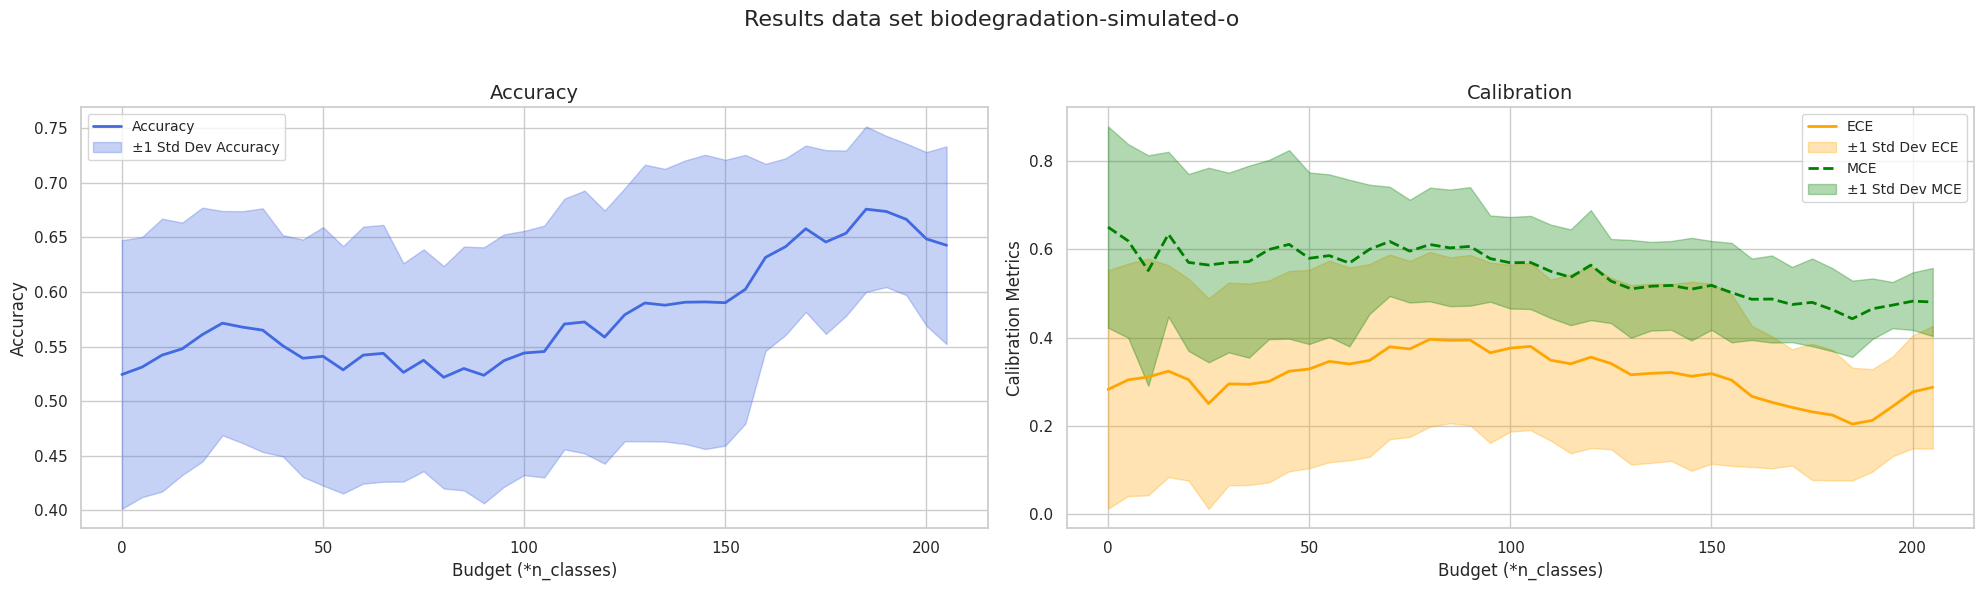

Data set: steel-plates-fault-simulated-o. Simulations: 20
Accuracy:0.653. ECE: 0.074. MCE: 0.292
Annotations per instance: 0.44. Max annotations: 1.05


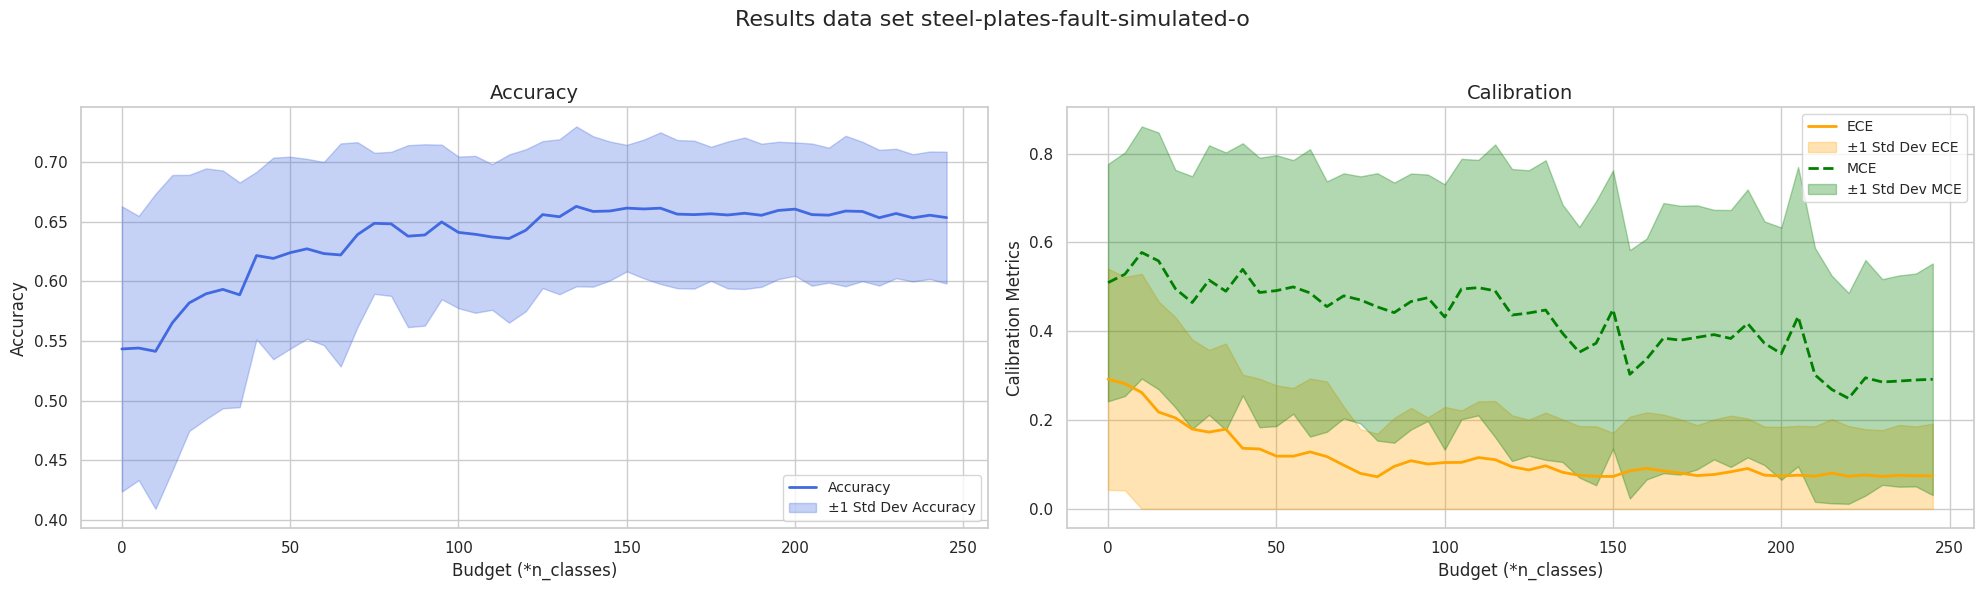

Data set: phoneme-simulated-o. Simulations: 20


KeyboardInterrupt: 

In [99]:
skip = ['ecoli', 'glass']
simulation_type = 'o' # e {o (uniform performance values), x (instance dependent performance), y (class dependent performance)}
n_simulations = 20

seeds = np.arange(n_simulations)
nbudget = 5

relabel = False
annotator = 0
annotator_selection = partial(select_fixed_annotator, annotator=annotator)

use = ['breast-cancer-wisconsin', 'biodegradation', 'steel-plates-fault', 'phoneme']

#for data_set_name in data_set_names:
for data_set_name in use:

	if data_set_name in skip: continue

	data_set_name = f'{data_set_name}-simulated-{simulation_type}'
	print(f'Data set: {data_set_name}. Simulations: {n_simulations}')	
	

	# classifier = GaussianNB
	classifier = partial(PWC, metric='rbf')

	results = []

	for seed in seeds:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore", category= RuntimeWarning)
			warnings.filterwarnings("ignore", category= FutureWarning)
			res = run_experiment(data_set_name=data_set_name, seed=1, classifier=partial(PWC, metric='rbf'), 
						nbudget=5, query_strategy=margin_qs, annnotator_selection=select_annotator_epm, 
						verbose=False, relabel=relabel
						)
		results.append(res)

	acc = [x['accuracies'] for x in results]
	ece = [x['ece'] for x in results]
	mce = [x['mce'] for x in results]
	api = [x['api'] for x in results]
	max_annotations = [x['max_annotations'] for x in results]

	last_means = [np.mean(l, axis=0)[-1].round(3) for l in [acc, ece, mce, api, max_annotations]]
	print(f'Accuracy:{last_means[0]}. ECE: {last_means[1]}. MCE: {last_means[2]}')
	print(f'Annotations per instance: {last_means[3]}. Max annotations: {last_means[4]}')
	x = np.arange(len(acc[0])) * nbudget
	sns.set_theme(style='whitegrid')

	# Create subplots
	fig, axes = plt.subplots(1, 2, figsize=(20, 6))

	# Plot accuracy on the left
	plot_mean_std(axes[0], acc, x, label="Accuracy", color="royalblue")
	axes[0].set_title("Accuracy", fontsize=14)
	axes[0].set_xlabel("Budget (*n_classes)", fontsize=12)
	axes[0].set_ylabel("Accuracy", fontsize=12)
	axes[0].legend(fontsize=10)

	# Plot ECE and MCE on the right
	plot_mean_std(axes[1], ece, x, label="ECE", color="orange")
	plot_mean_std(axes[1], mce, x, label="MCE", color="green", linestyle='--')
	axes[1].set_title("Calibration", fontsize=14)
	axes[1].set_xlabel("Budget (*n_classes)", fontsize=12)
	axes[1].set_ylabel("Calibration Metrics", fontsize=12)
	axes[1].legend(fontsize=10)

	# Set the overall title
	fig.suptitle(f"Results data set {data_set_name}", fontsize=16)

	# Adjust layout
	plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the overall title

	# Show the plot
	plt.show()

In [123]:
np.mean([np.arange(10) for i in range(10)],axis=0)[-1]

9.0

In [16]:
from sklearn.datasets import make_blobs
from plotting_functions import plot_decision_boundary

In [17]:
plot_decision_boundary

<function plotting_functions.plot_decision_boundary(model, ax, X, title, alpha)>

/home/nico/lmu/active_learning/multi_annotator/almulti/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


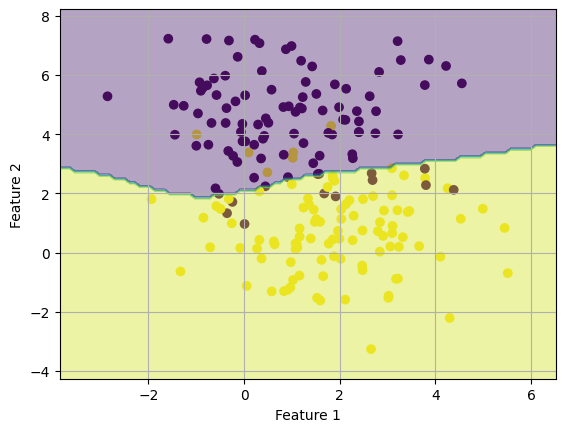

In [23]:
# generate dataset
X, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=0, cluster_std=1.5)
model = PWC(n_classes=2)
model.fit(X, y)

fig, ax = plt.subplots(1,1)
# visualize dataset
scatter = ax.scatter(X[:,0], X[:,1], c=y)
ax.set_title('Sample dataset with three classes')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True)
plot_decision_boundary(model, ax, X, '', .4)
plt.show()

Data set: blobs_n_2-simulated-o. Simulations: 20
Accuracy:0.833. ECE: 0.114. MCE: 0.18
Annotations per instance: 1.37. Max annotations: 3.55


/home/nico/lmu/active_learning/multi_annotator/almulti/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: 'c' argument has 3840 elements, which is inconsistent with 'x' and 'y' with size 400.

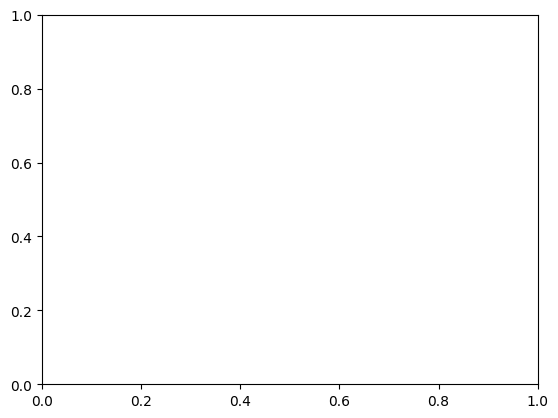

In [86]:
simulation_types = ['o', 'x', 'y'] # e {o (uniform performance values), x (instance dependent performance), y (class dependent performance)}
n_simulations = 20

seeds = np.arange(n_simulations)
nbudget = 5

relabel = True
annotator = 0
annotator_selection = partial(select_fixed_annotator, annotator=annotator)
#annotator_selection = select_random_annotator
#annotator_selection = select_annotator_epm

name = 'blobs_n_2'
#for data_set_name in data_set_names:
for simulation_type in simulation_types:

	data_set_name = f'{name}-simulated-{simulation_type}'
	print(f'Data set: {data_set_name}. Simulations: {n_simulations}')	
	
	# classifier = GaussianNB
	classifier = partial(PWC, metric='rbf')

	results = []

	for seed in seeds:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore", category= RuntimeWarning)
			warnings.filterwarnings("ignore", category= FutureWarning)
			res = run_experiment(data_set_name=data_set_name, seed=1, classifier=partial(PWC, metric='rbf'), 
						nbudget=5, query_strategy=margin_qs, annnotator_selection=select_annotator_epm, 
						verbose=False, relabel=relabel
						)
		results.append(res)

	acc = [x['accuracies'] for x in results]
	ece = [x['ece'] for x in results]
	mce = [x['mce'] for x in results]
	api = [x['api'] for x in results]
	max_annotations = [x['max_annotations'] for x in results]
	n_annotations = [x['n_annotations'] for x in results][-1]

	last_means = [np.mean(l, axis=0)[-1].round(3) for l in [acc, ece, mce, api, max_annotations]]

	print(f'Accuracy:{last_means[0]}. ECE: {last_means[1]}. MCE: {last_means[2]}')
	print(f'Annotations per instance: {last_means[3]}. Max annotations: {last_means[4]}')

	fig, ax = plt.subplots(1,1)
	
	# visualize dataset
	X, y_true, _ = load_data(data_set_name)
	model = PWC(n_classes=2)
	model.fit(X, y_true)
	scatter = ax.scatter(X[:,0], X[:,1], c=n_annotations)
	ax.set_title('Sample dataset with three classes')
	ax.set_xlabel('Feature 1')
	ax.set_ylabel('Feature 2')
	ax.grid(True)
	plot_decision_boundary(model, ax, X, '', .4)
	plt.show()

In [72]:
np.arange(10)[~np.ones(10,dtype=bool)]

array([], dtype=int64)

In [82]:
[np.max(r['n_annotations']) for r in results]

[np.int64(3),
 np.int64(2),
 np.int64(3),
 np.int64(3),
 np.int64(4),
 np.int64(3),
 np.int64(4),
 np.int64(2),
 np.int64(3),
 np.int64(5),
 np.int64(4),
 np.int64(5),
 np.int64(1),
 np.int64(4),
 np.int64(5),
 np.int64(2),
 np.int64(4),
 np.int64(4),
 np.int64(2),
 np.int64(4)]

In [80]:
len(results[0]['n_annotations'])

16

In [74]:
X, y_true, y = load_data(data_set_name)